## Artificial Neural Network 

#### Four companies listed on the JSE     
                                      : Netcare group limited
                                      : Sanlam limited
                                      : Nedbank group
                                      : Sanlam limited

In [1]:
#importing the modules in python
from pandas import Series
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 
import statsmodels.tsa.api as smt
import matplotlib.dates as dates
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pd.options.display.width = 600
import pandas_datareader.data as web


### Netcare

In [2]:
#load the data 
filename = 'ntc.csv'
netcareTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
netcareTS.head(5)


,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,1985,1990,1963,1975.0,514952
13/01/03,1974,1976,1960,1970.0,584990
13/01/04,1969,2011,1954,2000.0,3130465
13/01/07,2005,2010,1977,1990.0,1483949
13/01/08,2000,2000,1986,2000.0,1269313


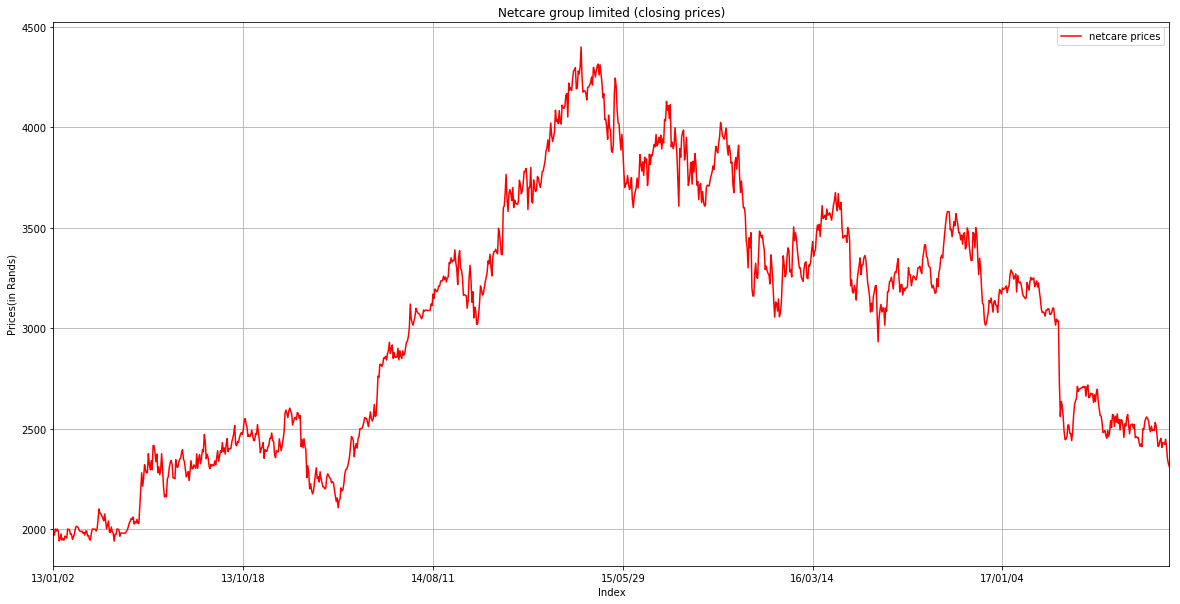

In [3]:
plt.figure(figsize=(20,10))
netcareTS["Close"].plot(label="netcare prices",color="red")
plt.grid(True)
plt.title("Netcare group limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

$\textbf{Log-returns}$

To analyze the stock price, we usually calculate the logged return of
the stock to make the data stationary

$r_{t}=log\Big(\frac{p_{t}}{p_{t-1}}\Big)$, where $p_{t}$ is the stock price at time $t$

In [4]:
#The log-returns
returns=np.log((netcareTS["Close"])/(netcareTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

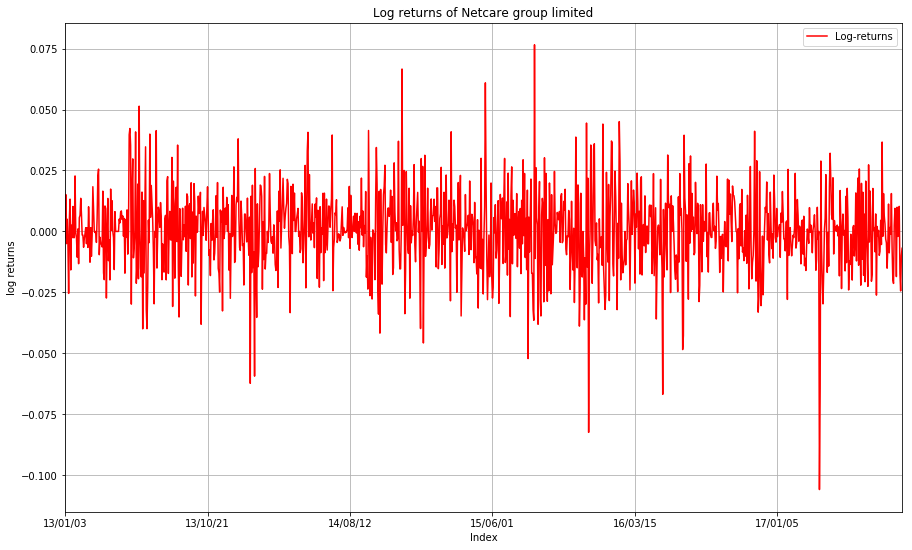

In [5]:
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Netcare group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

$\textbf{Split the data into multiple training and testing sets}$


### split1: Train 500  Test:200
###  split2: Train 700  Test:200

## Multiplayer peceptron

##### split1: Train 500  Test:200

In [6]:
x_train=returns[0:500]
x_test=returns[500:700]
y_train=returns[0:500]
y_test=returns[500:700]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape

(200, 1)

In [7]:
#Standardization refers to shifting the distribution of each attribute to have a mean of zero
#and a standard deviation of one (unit variance). It is useful to standardize attributes 
#for a model that relies on the distribution of attributes such as Gaussian processes.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [8]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
        return onehot.T
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        #y_valid_pred = self.predict(X_valid)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self

In [9]:
nn = NeuralNetMLP(n_hidden=2,
            l2=0.0006,
           epochs=4800,
            eta=0.0006,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)

(500, 1)


4800/4800 | Cost: 0.00 | Train Acc.: 0.00 

(500, 1)


In [10]:
y_test_pred = nn.predict(x_test)


(200, 1)


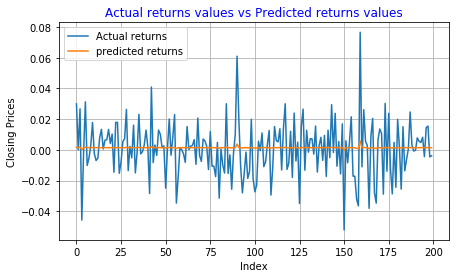

([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0], 200)
Predicted data:
([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,

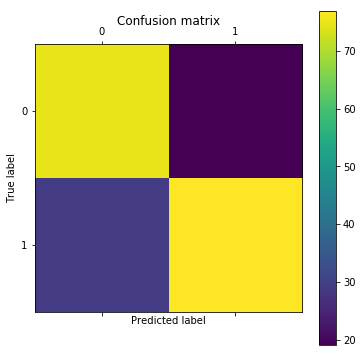

In [11]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

### split2: Train 700  Test:200

In [12]:
returns=returns.dropna()
x_train=returns[0:700]
x_test=returns[700:900]
y_train=returns[0:700]
y_test=returns[700:900]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape

(200, 1)

In [13]:
#Standardization refers to shifting the distribution of each attribute to have a mean of zero
#and a standard deviation of one (unit variance). It is useful to standardize attributes 
#for a model that relies on the distribution of attributes such as Gaussian processes.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [14]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):    
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
        return onehot.T
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        #y_valid_pred = self.predict(X_valid)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self

In [15]:
nn = NeuralNetMLP(n_hidden=2,
            l2=0.0006,
            epochs=4600,
            eta=0.0006,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)

(700, 1)


4600/4600 | Cost: 0.00 | Train Acc.: 0.00 

(700, 1)


In [16]:
y_test_pred = nn.predict(x_test)

(200, 1)


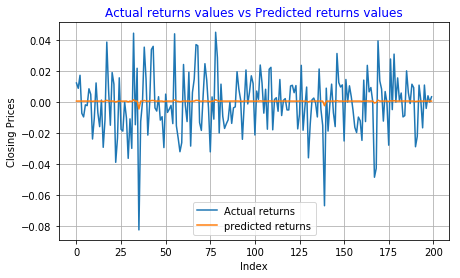

([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0], 200)
Predicted data:
([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,

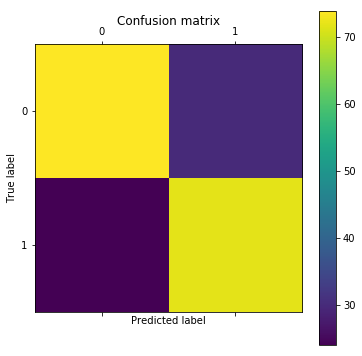

In [17]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

## Santam Group Limited

In [18]:
#load the data 
filename = 'snt.csv'
santamTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
santamTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,18950,19321,18950,18990.0,29044
13/01/03,19000,19001,18979,18990.0,7150
13/01/04,19000,19000,18482,18597.0,14707
13/01/07,19000,19000,18654,18850.0,7530
13/01/08,19000,19000,18736,19000.0,8986


In [19]:
#The log-returns
returns=np.log((santamTS["Close"])/(santamTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

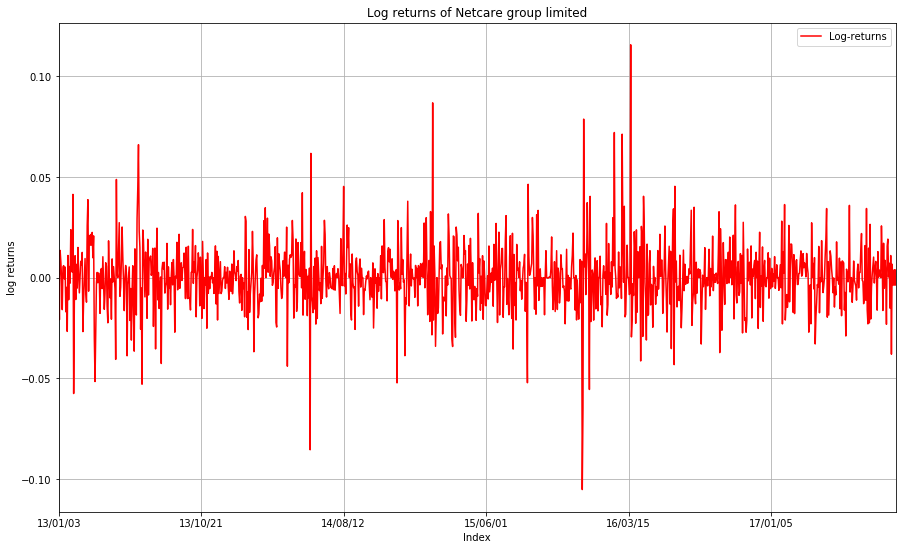

In [20]:
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Netcare group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

### split1   Train:500 Test:200

In [21]:
returns=returns.dropna()
x_train=returns[0:500]
x_test=returns[500:700]
y_train=returns[0:500]
y_test=returns[500:700]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [22]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):      
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
        return onehot.T
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)#Linear activation function
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        #y_valid_pred = self.predict(X_valid)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        #valid_acc = ((np.sum(y_valid ==
        #        y_valid_pred)).astype(np.float) /
         #       X_valid.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self
nn = NeuralNetMLP(n_hidden=2,
            l2=0.0006,
            epochs=4800,
            eta=0.0006,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)
y_test_pred = nn.predict(x_test)

(500, 1)


4800/4800 | Cost: 0.00 | Train Acc.: 0.00 

(500, 1)
(200, 1)


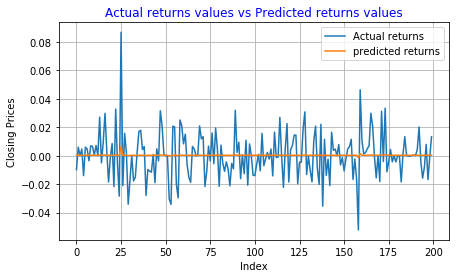

([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1], 200)
Predicted data:
([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,

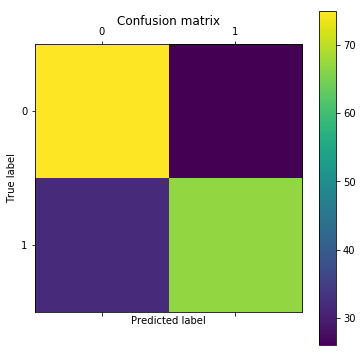

In [23]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

### split 2 Train:700  Test: 200

In [24]:
returns=returns.dropna()
x_train=returns[0:700]
x_test=returns[700:900]
y_train=returns[0:700]
y_test=returns[700:900]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [25]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):  
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
            #-1 the last row and idx(index) and val the value of the y
        #print(onehot,y_train)
        return onehot.T
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)#Linear activation function
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self
nn = NeuralNetMLP(n_hidden=2,
            l2=0.0006,
            epochs=9800,
            eta=0.0003,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)
y_test_pred = nn.predict(x_test)

(700, 1)


9800/9800 | Cost: 0.00 | Train Acc.: 0.00 

(700, 1)
(200, 1)


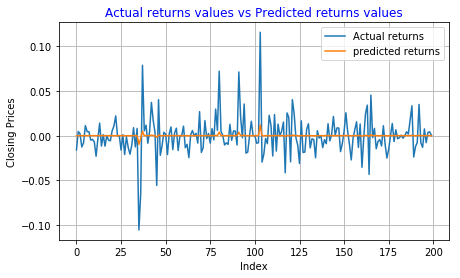

([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1], 200)
Predicted data:
([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,

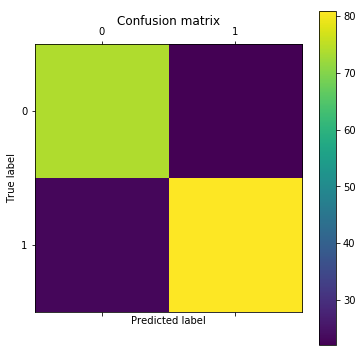

In [26]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

### Nedbank group

In [27]:
#load the data 
filename = 'ned.csv'
nedbankTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
nedbankTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,18888,19001,18755,18975,292269
13/01/03,19000,19001,18741,18947,182826
13/01/04,19000,19000,18750,18832,191315
13/01/07,19079,19184,18818,19025,296281
13/01/08,19010,19159,18806,18977,241453


In [28]:
#The log-returns
returns=np.log((nedbankTS["Close"])/(nedbankTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

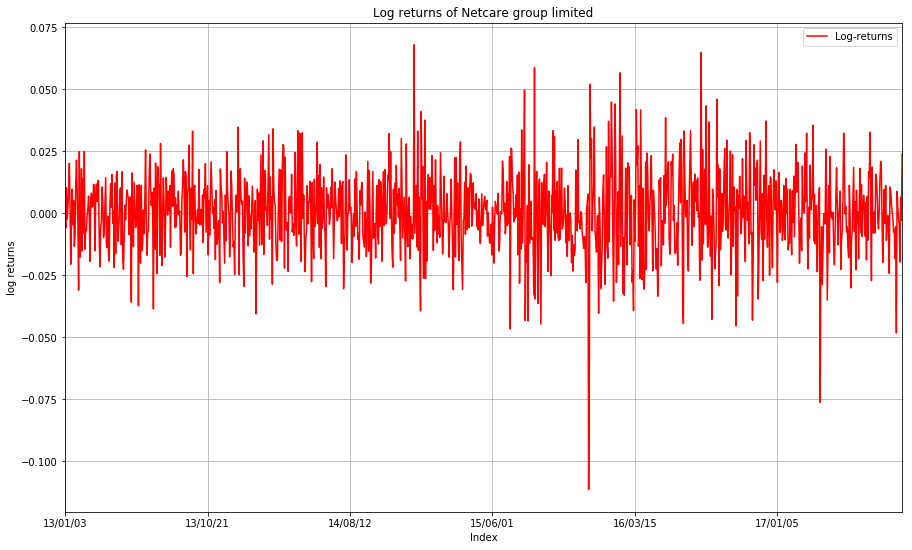

In [29]:
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Netcare group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

### split 1 Train:500 Test: 200

In [30]:
returns=returns.dropna()
x_train=returns[0:500]
x_test=returns[500:700]
y_train=returns[0:500]
y_test=returns[500:700]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [31]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):  
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
            #-1 the last row and idx(index) and val the value of the y
        #print(onehot,y_train)
        return onehot.T
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)#Linear activation function
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        #cost=((((y_predict-y_target)**2).sum())/2.0)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self
nn = NeuralNetMLP(n_hidden=2,
            l2=0.0006,
            epochs=5400,
            eta=0.0006,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)
y_test_pred = nn.predict(x_test)

(500, 1)


5400/5400 | Cost: 0.00 | Train Acc.: 0.00 

(500, 1)
(200, 1)


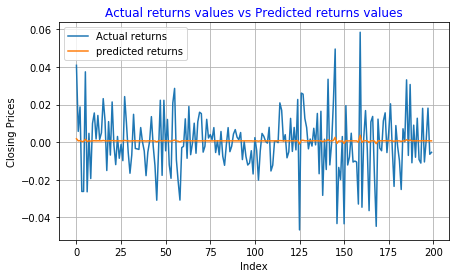

([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,

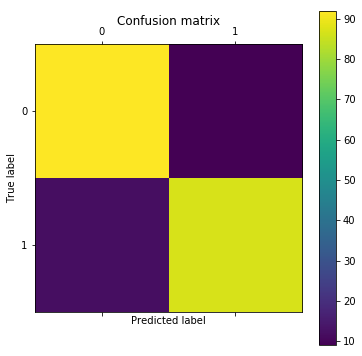

In [32]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

### Split 2 Train: 700 Test: 200 

In [33]:
returns=returns.dropna()
x_train=returns[0:700]
x_test=returns[700:900]
y_train=returns[0:700]
y_test=returns[700:900]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [34]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=30,
            l2=0., epochs=100, eta=0.001,
            shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
        return onehot.T
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)#Linear activation function
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        #y_valid_pred = self.predict(X_valid)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        #valid_acc = ((np.sum(y_valid ==
        #        y_valid_pred)).astype(np.float) /
         #       X_valid.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        #self.eval_['valid_acc'].append(valid_acc)
        return self
nn = NeuralNetMLP(n_hidden=2,
            l2=0.0006,
            epochs=4900,
            eta=0.0006,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)
y_test_pred = nn.predict(x_test)

(700, 1)


4900/4900 | Cost: 0.00 | Train Acc.: 0.00 

(700, 1)
(200, 1)


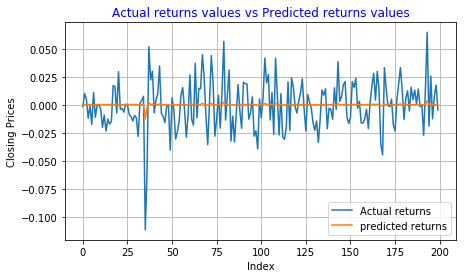

([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0], 200)
Predicted data:
([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,

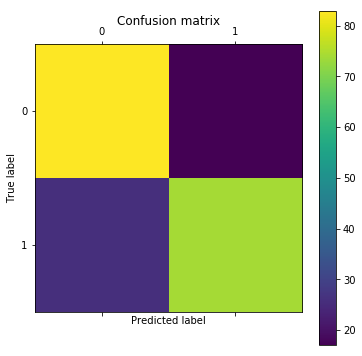

In [35]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

### Sanlam  Group Ltd

In [36]:
#load the data 
filename = 'slm.csv'
sanlamTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
sanlamTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,4520.0,4550,4509,4545,2035263
13/01/03,4550.0,4558,4516,4549,1488016
13/01/04,4512.0,4600,4512,4598,1498258
13/01/07,4600.0,4640,4568,4609,1705254
13/01/08,4625.0,4631,4601,4631,1989724


In [37]:
#The log-returns
returns=np.log((sanlamTS["Close"])/(sanlamTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

In [38]:
returns=returns.dropna()
x_train=returns[0:500]
x_test=returns[500:700]
y_train=returns[0:500]
y_test=returns[500:700]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [39]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):  
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
            #-1 the last row and idx(index) and val the value of the y
        #print(onehot,y_train)
        return onehot.T
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-(z)))
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)#Linear activation function
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self
nn = NeuralNetMLP(n_hidden=2,
            l2=0.00054,
            epochs=3930,
            eta=0.0007,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)
y_test_pred = nn.predict(x_test)

(500, 1)


3930/3930 | Cost: 0.00 | Train Acc.: 0.00 

(500, 1)
(200, 1)


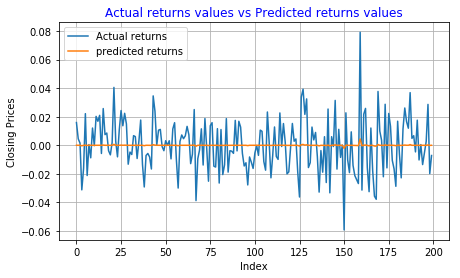

([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], 200)
Predicted data:
([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,

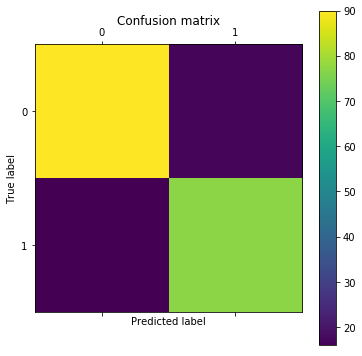

In [40]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

#### Split 2 Train:700 Test:200

In [41]:
returns=returns.dropna()
x_train=returns[0:700]
x_test=returns[700:900]
y_train=returns[0:700]
y_test=returns[700:900]
x_train=np.reshape(x_train,[len(y_train),1])
x_train.shape
x_test=np.reshape(x_test,[len(y_test),1])
x_test.shape
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [42]:
import math
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_hidden : int (default: 30)
    l2       : float (default: 0.)  Lambda value for L2-regularization.
                              No regularization if l2=0. (default)
    epochs   : int (default: 100)  Number of passes over the training set.
    eta      : float (default: 0.001)   Learning rate.
    shuffle  : bool (default: True) Shuffles training data every epoch
                                   if True to prevent circles.
    minibatch_size : int (default: 1)  Number of training samples per minibatch.
    seed     : int (default: None)    Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
    Dictionary collecting the cost, training accuracy, 
      and validation accuracy for each epoch during training.
    """
    #def __init__(self, n_hidden=30,
     #       l2=0., epochs=100, eta=0.001,
    #       shuffle=True, minibatch_size=1, seed=None):
    def __init__(self, n_hidden=2,
            l2=0.0006, epochs=3000, eta=0.0006,
            shuffle=True, minibatch_size=1, seed=None):  
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((1, y.shape[0]))
        for idx, val in enumerate(y.astype(float)):
            onehot[-1, idx] = val
            #-1 the last row and idx(index) and val the value of the y
        #print(onehot,y_train)
        return onehot.T
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-(z)))
    def _tangent(self,z):
        """
        Compute the tangent function
        """
        #return (np.sinh(z)/np.cosh(z))
        return np.tanh(z)
    def _forward(self, X):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
            # [n_samples, n_features] dot [n_features, n_hidden]
            # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
            # step 2: activation of hidden layer
        a_h = self._tangent(z_h)
         # step 3: net input of output layer
            # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
            # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
            # step 4: activation output layer
        a_out=self._tangent(z_out)#Linear activation function
        return z_h, a_h, z_out, a_out
    def _mse(self, y_predict, y_target):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels) one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units] Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float   Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        cost= np.mean((y_predict-y_target)**2)+L2_term
        #cost=((((y_predict-y_target)**2).sum())/2.0)+L2_term
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        print(np.shape(z_out))
        y_pred = np.max(z_out, axis=1)
        return y_pred
    def fit(self, x_train, y_train):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = y_train.shape[0] # no. of class
            #labels
        n_features = x_train.shape[1]
            ########################
            # Weight initialization
            ########################
            # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                    size=(n_features,
                    self.n_hidden))
            # weights for hidden -> output
        self.b_out = np.zeros(1)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden,
                1))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train)
        print(y_train_enc.shape)
        # iterate over training epochs
        for i in range(self.epochs):
                # iterate over minibatches
            indices = np.arange(x_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # forward propagation
            z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])
            ##################
            # Backpropagation
            ##################
                # [n_samples, n_classlabels]
            sigma_out = a_out -y_train_enc[batch_idx]
            # [n_samples, n_hidden]
            #sigmoid_derivative_h = a_h * (1. - a_h)
            #tangent_derivative= (1-(np.sinh(z_h)/np.cosh(z_h))**2)
            tangent_derivative=1-((np.exp(z_h) -np.exp(-z_h))**2/(np.exp(z_h)+np.exp(-z_h))**2)
            #tangent_derivative=1-np.tanh(a_h)*np.tanh(a_h)
            # [n_samples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_samples, n_hidden]
            #sigma_h = (np.dot(sigma_out, self.w_out.T) *
            #sigmoid_derivative_h)
            sigma_h = (np.dot(sigma_out, self.w_out.T) *
            tangent_derivative)
            #sigma_h = (np.dot(sigma_out, self.w_out.T))
                # [n_features, n_samples] dot [n_samples,
                # n_hidden]
                # -> [n_features, n_hidden]
            grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
            grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, sigma_out)
            grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
            delta_w_h = (grad_w_h + self.l2*self.w_h)
            delta_b_h = grad_b_h # bias is not regularized
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h
            delta_w_out = (grad_w_out + self.l2*self.w_out)
            delta_b_out = grad_b_out # bias is not regularized
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out
        #############
        # Evaluation
        #############
            # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(x_train)
        cost = self._mse(y_train_enc,
            a_out)
        y_train_pred = self.predict(x_train)
        train_acc = ((np.sum(y_train ==
                y_train_pred)).astype(np.float) /
                    x_train.shape[0])
        sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train Acc.: %.2f '
            %
            (epoch_strlen, i+1, self.epochs,
            cost,
            train_acc*100))
        sys.stderr.flush()
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        return self
nn = NeuralNetMLP(n_hidden=2,
            l2=0.00054,
            epochs=4600,
            eta=0.00056,
            minibatch_size=1,
            shuffle=True,
            seed=1)
nn.fit(x_train, y_train)
y_test_pred = nn.predict(x_test)

(700, 1)


4600/4600 | Cost: 0.00 | Train Acc.: 0.00 

(700, 1)
(200, 1)


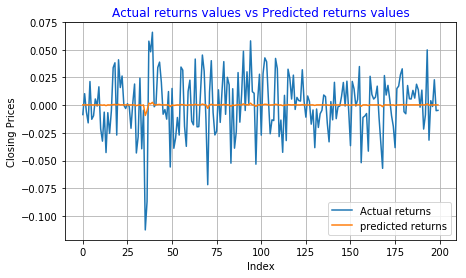

([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0], 200)
Predicted data:
([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,

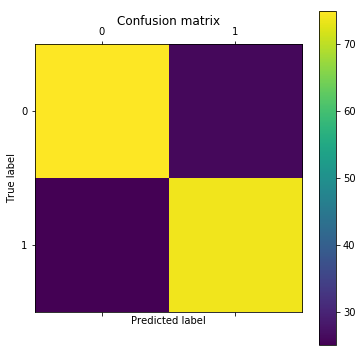

In [43]:
y_test=np.array(y_test)
test_predicted=np.array(y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(y_test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#converting data to binary o or 1
binary_test=[]
for t in range(0,len(y_test)):
    if y_test[t-1]>=y_test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

# Accuracy for ANN: 
# Train:500 Test:200, Train:700 Test:200

In [44]:
import pandas as pd    
steps=[[76,73],[71,77.5],[89.5,78.5],[83.5,74.5]]        

In [45]:
data=pd.DataFrame(steps,index=['Netcare','Santam','Sanlam','Nedbank'],columns=["Train:500 Test:200","Train:700 Test:200"])
data

,Train:500 Test:200,Train:700 Test:200
Netcare,76.0,73.0
Santam,71.0,77.5
Sanlam,89.5,78.5
Nedbank,83.5,74.5


https://theclevermachine.wordpress.com/2014/09/08/derivation-derivatives-for-common-neural-network-activation-functions/

https://www.math10.com/en/algebra/hyperbolic-functions/hyperbolic-functions.html

https://datascience.stackexchange.com/questions/15662/my-neural-network-is-not-learning-anything

https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/supervised_learning/multilayer_perceptron.py

https://theclevermachine.wordpress.com/2014/09/08/derivation-derivatives-for-common-neural-network-activation-functions/